# Cross Validation & Hyperparameter Tuning Workshop
**CMSC 173 - Machine Learning**

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/njpinton/CMSC173/blob/main/06-CrossValidation/notebooks/cross_validation_workshop.ipynb)

---

## 📚 Learning Objectives

By the end of this workshop, you will be able to:
1. **Implement** different cross-validation methods (holdout, k-fold, LOOCV)
2. **Compare** hyperparameter search strategies (grid search vs random search)
3. **Interpret** learning curves and validation curves
4. **Apply** best practices to avoid common pitfalls
5. **Build** a complete model selection pipeline

---

## 🛠️ Setup & Imports

In [1]:
# Essential imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import (
    train_test_split, cross_val_score, KFold, StratifiedKFold,
    GridSearchCV, RandomizedSearchCV, learning_curve, validation_curve
)
from sklearn.datasets import make_classification, load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

print("✅ Setup complete! Ready to explore cross-validation.")

✅ Setup complete! Ready to explore cross-validation.


---
## 🎯 Part 1: Understanding the Problem

### Why Do We Need Cross-Validation?

Let's start with a simple example to understand the problem:

In [2]:
# Create a simple dataset
X, y = make_classification(n_samples=1000, n_features=20, n_informative=10, 
                          n_redundant=10, n_clusters_per_class=1, random_state=42)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Dataset shape: {X.shape}")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Class distribution: {np.bincount(y)}")

Dataset shape: (1000, 20)
Training set: 800 samples
Test set: 200 samples
Class distribution: [499 501]


### The Wrong Way: Using Training Error

In [3]:
# Train a model and check training vs test performance
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Training accuracy (overly optimistic!)
train_accuracy = model.score(X_train, y_train)
test_accuracy = model.score(X_test, y_test)

print(f"Training Accuracy: {train_accuracy:.3f}")
print(f"Test Accuracy: {test_accuracy:.3f}")
print(f"Gap: {train_accuracy - test_accuracy:.3f}")
print("\n❌ Training accuracy is overly optimistic!")
print("❌ We can't trust it for model selection.")

Training Accuracy: 1.000
Test Accuracy: 0.985
Gap: 0.015

❌ Training accuracy is overly optimistic!
❌ We can't trust it for model selection.


---
## 🔄 Part 2: Cross-Validation Methods

### Method 1: Holdout Validation

In [4]:
def holdout_validation(X, y, model, test_size=0.2, random_state=42):
    """Simple holdout validation"""
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    model.fit(X_train, y_train)
    val_score = model.score(X_val, y_val)
    
    return val_score

# Test with different random states to show variance
model = RandomForestClassifier(n_estimators=100, random_state=42)
holdout_scores = []

for seed in range(0, 10):
    score = holdout_validation(X_train, y_train, model, random_state=seed)
    holdout_scores.append(score)

print(f"Holdout Validation Scores: {holdout_scores}")
print(f"Mean: {np.mean(holdout_scores):.3f} ± {np.std(holdout_scores):.3f}")
print(f"Range: [{min(holdout_scores):.3f}, {max(holdout_scores):.3f}]")
print("\n⚠️  High variance! Results depend on the specific split.")

Holdout Validation Scores: [0.975, 0.9625, 0.98125, 0.93125, 0.96875, 0.975, 0.9875, 0.9625, 0.9875, 0.96875]
Mean: 0.970 ± 0.016
Range: [0.931, 0.988]

⚠️  High variance! Results depend on the specific split.


### Method 2: K-Fold Cross-Validation

In [5]:
# K-fold cross-validation
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Try different values of k
k_values = [3, 5, 10]
cv_results = {}

for k in k_values:
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    cv_results[k] = scores
    
    print(f"{k}-Fold CV: {scores.mean():.3f} ± {scores.std():.3f}")

print("\n✅ K-fold CV provides more stable estimates!")
print("✅ Uses all data for both training and validation.")

3-Fold CV: 0.965 ± 0.010


5-Fold CV: 0.964 ± 0.021


10-Fold CV: 0.971 ± 0.021

✅ K-fold CV provides more stable estimates!
✅ Uses all data for both training and validation.


### Method 3: Stratified K-Fold (Important for Imbalanced Data)

In [6]:
# Compare regular vs stratified k-fold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)

# Regular k-fold
regular_scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')

# Stratified k-fold  
stratified_scores = cross_val_score(model, X_train, y_train, cv=stratified_kfold, scoring='accuracy')

print(f"Regular K-Fold:    {regular_scores.mean():.3f} ± {regular_scores.std():.3f}")
print(f"Stratified K-Fold: {stratified_scores.mean():.3f} ± {stratified_scores.std():.3f}")
print("\n💡 Stratified preserves class distribution in each fold.")

Regular K-Fold:    0.964 ± 0.021
Stratified K-Fold: 0.967 ± 0.016

💡 Stratified preserves class distribution in each fold.


---
## 🔍 Part 3: Hyperparameter Search

### Grid Search vs Random Search Comparison

Let's compare these methods on a real dataset:

In [7]:
# Load a real dataset
data = load_breast_cancer()
X_real, y_real = data.data, data.target

# Scale the features
scaler = StandardScaler()
X_real_scaled = scaler.fit_transform(X_real)

# Split the data
X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(
    X_real_scaled, y_real, test_size=0.2, random_state=42
)

print(f"Real dataset: {data.feature_names[0]} and others")
print(f"Shape: {X_real.shape}")
print(f"Classes: {data.target_names}")

Real dataset: mean radius and others
Shape: (569, 30)
Classes: ['malignant' 'benign']


In [8]:
# Define parameter space for SVM
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1]
}

# Grid Search
grid_search = GridSearchCV(
    SVC(random_state=42), param_grid, 
    cv=5, scoring='accuracy', n_jobs=-1
)

grid_search.fit(X_train_real, y_train_real)

print("🔍 Grid Search Results:")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV score: {grid_search.best_score_:.3f}")
print(f"Total fits: {len(grid_search.cv_results_['params'])}")

🔍 Grid Search Results:
Best parameters: {'C': 10, 'gamma': 0.01}
Best CV score: 0.974
Total fits: 16


In [9]:
# Random Search (same number of evaluations)
from scipy.stats import uniform, loguniform

param_dist = {
    'C': loguniform(0.1, 100),
    'gamma': loguniform(0.001, 1)
}

random_search = RandomizedSearchCV(
    SVC(random_state=42), param_dist,
    n_iter=16, cv=5, scoring='accuracy', 
    random_state=42, n_jobs=-1
)

random_search.fit(X_train_real, y_train_real)

print("🎲 Random Search Results:")
print(f"Best parameters: {random_search.best_params_}")
print(f"Best CV score: {random_search.best_score_:.3f}")
print(f"Total fits: {len(random_search.cv_results_['params'])}")

🎲 Random Search Results:
Best parameters: {'C': np.float64(6.847920095574778), 'gamma': np.float64(0.002621087878265439)}
Best CV score: 0.978
Total fits: 16


In [10]:
# Compare final test performance
grid_test_score = grid_search.score(X_test_real, y_test_real)
random_test_score = random_search.score(X_test_real, y_test_real)

print(f"\n🏆 Final Test Scores:")
print(f"Grid Search:   {grid_test_score:.3f}")
print(f"Random Search: {random_test_score:.3f}")

if random_test_score >= grid_test_score:
    print("\n✨ Random search found equally good (or better) results with same budget!")
else:
    print("\n📊 Grid search won this time, but random search is often competitive.")


🏆 Final Test Scores:
Grid Search:   0.982
Random Search: 0.982

✨ Random search found equally good (or better) results with same budget!


---
## 📈 Part 4: Learning & Validation Curves

### Learning Curves: Diagnosing Bias vs Variance

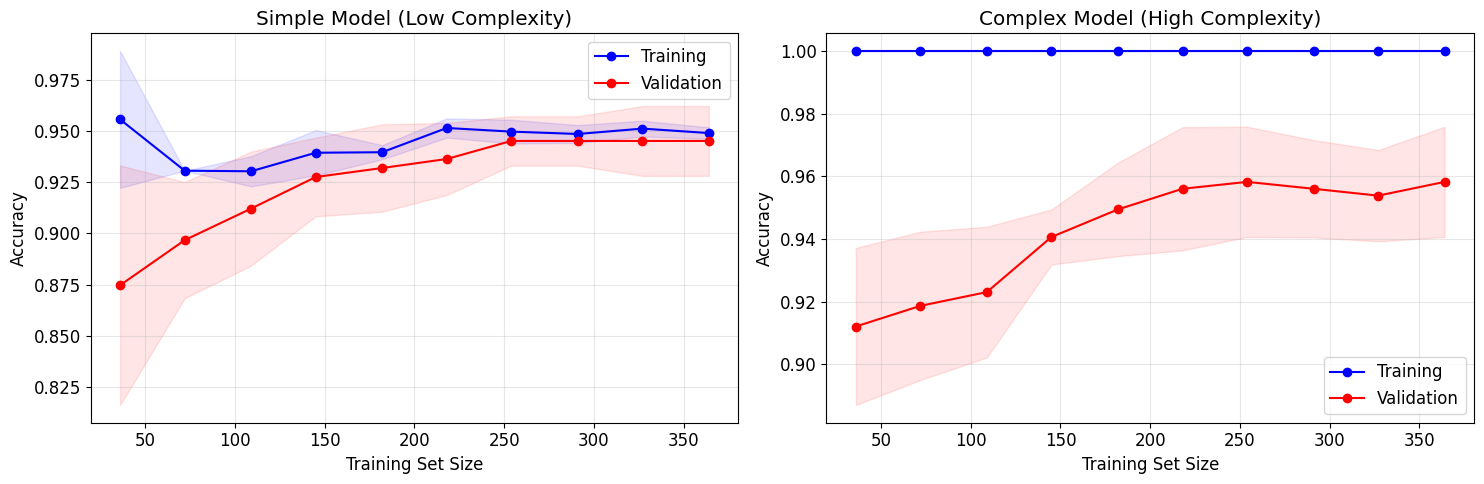

In [11]:
# Create learning curves for different models
def plot_learning_curves(models, X, y, title="Learning Curves"):
    fig, axes = plt.subplots(1, len(models), figsize=(15, 5))
    if len(models) == 1:
        axes = [axes]
    
    for i, (name, model) in enumerate(models.items()):
        train_sizes, train_scores, val_scores = learning_curve(
            model, X, y, cv=5, n_jobs=-1,
            train_sizes=np.linspace(0.1, 1.0, 10),
            random_state=42
        )
        
        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        val_mean = np.mean(val_scores, axis=1)
        val_std = np.std(val_scores, axis=1)
        
        axes[i].plot(train_sizes, train_mean, 'o-', color='blue', label='Training')
        axes[i].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
        
        axes[i].plot(train_sizes, val_mean, 'o-', color='red', label='Validation')
        axes[i].fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')
        
        axes[i].set_title(f'{name}')
        axes[i].set_xlabel('Training Set Size')
        axes[i].set_ylabel('Accuracy')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Compare different model complexities
models = {
    'Simple Model (Low Complexity)': LogisticRegression(C=0.01, random_state=42),
    'Complex Model (High Complexity)': RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)
}

plot_learning_curves(models, X_train_real, y_train_real)

### Validation Curves: Finding Optimal Hyperparameters

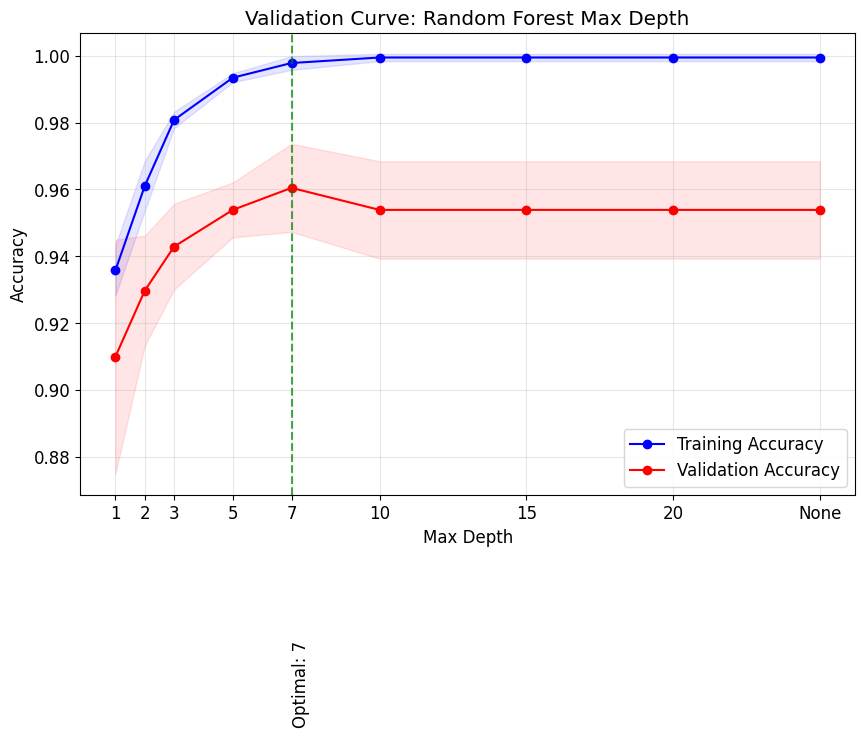

🎯 Optimal max_depth: 7
Validation accuracy: 0.960 ± 0.013


In [12]:
# Validation curve for Random Forest max_depth
param_range = [1, 2, 3, 5, 7, 10, 15, 20, None]
# Convert None to a large number for plotting
param_range_plot = [1, 2, 3, 5, 7, 10, 15, 20, 25]

train_scores, val_scores = validation_curve(
    RandomForestClassifier(n_estimators=50, random_state=42),
    X_train_real, y_train_real,
    param_name='max_depth', param_range=param_range,
    cv=5, scoring='accuracy', n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(param_range_plot, train_mean, 'o-', color='blue', label='Training Accuracy')
plt.fill_between(param_range_plot, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')

plt.plot(param_range_plot, val_mean, 'o-', color='red', label='Validation Accuracy')
plt.fill_between(param_range_plot, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')

plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Validation Curve: Random Forest Max Depth')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(param_range_plot, [str(p) if p != 25 else 'None' for p in param_range_plot])

# Find optimal depth
optimal_idx = np.argmax(val_mean)
optimal_depth = param_range[optimal_idx]
plt.axvline(x=param_range_plot[optimal_idx], color='green', linestyle='--', alpha=0.7)
plt.text(param_range_plot[optimal_idx], 0.8, f'Optimal: {optimal_depth}', rotation=90)

plt.show()

print(f"🎯 Optimal max_depth: {optimal_depth}")
print(f"Validation accuracy: {val_mean[optimal_idx]:.3f} ± {val_std[optimal_idx]:.3f}")

---
## ⚠️ Part 5: Common Pitfalls & Best Practices

### Pitfall 1: Data Leakage

**Wrong Way:** Scaling before splitting

In [13]:
# ❌ WRONG: Scale entire dataset first
X_wrong = StandardScaler().fit_transform(X_real)
X_train_wrong, X_test_wrong, y_train_wrong, y_test_wrong = train_test_split(
    X_wrong, y_real, test_size=0.2, random_state=42
)

model_wrong = SVC(C=1, gamma=0.1)
model_wrong.fit(X_train_wrong, y_train_wrong)
wrong_score = model_wrong.score(X_test_wrong, y_test_wrong)

# ✅ RIGHT: Scale after splitting
X_train_right, X_test_right, y_train_right, y_test_right = train_test_split(
    X_real, y_real, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_right = scaler.fit_transform(X_train_right)
X_test_right = scaler.transform(X_test_right)  # Only transform, don't fit!

model_right = SVC(C=1, gamma=0.1)
model_right.fit(X_train_right, y_train_right)
right_score = model_right.score(X_test_right, y_test_right)

print(f"❌ Wrong approach (data leakage):  {wrong_score:.3f}")
print(f"✅ Right approach (no leakage):   {right_score:.3f}")
print(f"Difference: {wrong_score - right_score:.3f}")
print("\n💡 Data leakage can lead to overly optimistic results!")

❌ Wrong approach (data leakage):  0.965
✅ Right approach (no leakage):   0.965
Difference: 0.000

💡 Data leakage can lead to overly optimistic results!


### Best Practice: Complete Pipeline

In [14]:
from sklearn.pipeline import Pipeline

# Create a complete pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC())
])

# Define parameter grid for pipeline
param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__gamma': [0.001, 0.01, 0.1]
}

# Grid search with pipeline (no data leakage!)
grid_search_pipeline = GridSearchCV(
    pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1
)

# Split raw data
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X_real, y_real, test_size=0.2, random_state=42
)

# Fit pipeline
grid_search_pipeline.fit(X_train_raw, y_train_raw)

print(f"✅ Best pipeline CV score: {grid_search_pipeline.best_score_:.3f}")
print(f"✅ Best parameters: {grid_search_pipeline.best_params_}")
print(f"✅ Final test score: {grid_search_pipeline.score(X_test_raw, y_test_raw):.3f}")
print("\n🎉 Pipeline ensures no data leakage during cross-validation!")

✅ Best pipeline CV score: 0.974
✅ Best parameters: {'classifier__C': 10, 'classifier__gamma': 0.01}
✅ Final test score: 0.982

🎉 Pipeline ensures no data leakage during cross-validation!


---
## 🏃‍♀️ **STUDENT ACTIVITY: Build Your Own Model Selection Pipeline**

**Your Mission:** Build a complete model selection pipeline and find the best model for the breast cancer dataset.

**Requirements:**
1. Compare at least 3 different algorithms
2. Use proper cross-validation (no data leakage!)
3. Tune hyperparameters for each model
4. Report final results with confidence intervals
5. Make a recommendation

**Time Limit:** 15 minutes

### Step 1: Setup Your Experiment

In [15]:
# TODO: Load data and create train/test split
# Hint: Use the breast cancer dataset we loaded earlier

# Your code here:


### Step 2: Define Models and Parameter Grids

In [16]:
# TODO: Create pipelines for 3 different models
# Suggestions: Logistic Regression, SVM, Random Forest
# Don't forget to include StandardScaler!

# Example structure:
# models = {
#     'Logistic Regression': Pipeline([...]),
#     'SVM': Pipeline([...]),
#     'Random Forest': Pipeline([...])
# }
# 
# param_grids = {
#     'Logistic Regression': {...},
#     'SVM': {...},
#     'Random Forest': {...}
# }

# Your code here:


### Step 3: Perform Grid Search for Each Model

In [17]:
# TODO: Use GridSearchCV to find best parameters for each model
# Print results for each model

# Your code here:


### Step 4: Compare Models and Make Final Evaluation

In [18]:
# TODO: Compare all models and select the best one
# Evaluate on test set and report results

# Your code here:


### Step 5: Your Recommendation

**TODO: Write your analysis here**

1. Which model performed best?
2. What were the optimal hyperparameters?
3. How confident are you in the results?
4. What would you recommend for production use?

*Your analysis goes here...*

---
## 🎯 **SOLUTION** (Don't peek until you're done!)

<details>
<summary>Click to reveal solution</summary>

In [19]:
# SOLUTION - Complete model selection pipeline
from sklearn.metrics import classification_report

# Step 1: Data setup
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X_real, y_real, test_size=0.2, random_state=42, stratify=y_real
)

# Step 2: Define models and parameters
models = {
    'Logistic Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(random_state=42, max_iter=1000))
    ]),
    'SVM': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', SVC(random_state=42))
    ]),
    'Random Forest': Pipeline([
        ('classifier', RandomForestClassifier(random_state=42))
    ])
}

param_grids = {
    'Logistic Regression': {
        'classifier__C': [0.1, 1, 10, 100]
    },
    'SVM': {
        'classifier__C': [0.1, 1, 10],
        'classifier__gamma': ['scale', 0.001, 0.01]
    },
    'Random Forest': {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 10, 20]
    }
}

# Step 3: Perform grid search
results = {}

for name, model in models.items():
    print(f"\n🔍 Training {name}...")
    
    grid_search = GridSearchCV(
        model, param_grids[name], 
        cv=5, scoring='accuracy', n_jobs=-1
    )
    
    grid_search.fit(X_train_final, y_train_final)
    
    results[name] = {
        'best_score': grid_search.best_score_,
        'best_params': grid_search.best_params_,
        'best_model': grid_search.best_estimator_
    }
    
    print(f"Best CV score: {grid_search.best_score_:.3f}")
    print(f"Best parameters: {grid_search.best_params_}")

# Step 4: Compare models
print("\n" + "="*50)
print("📊 FINAL COMPARISON")
print("="*50)

best_model_name = max(results.keys(), key=lambda x: results[x]['best_score'])
best_model = results[best_model_name]['best_model']

for name, result in results.items():
    test_score = result['best_model'].score(X_test_final, y_test_final)
    marker = "🏆" if name == best_model_name else "  "
    print(f"{marker} {name:20} | CV: {result['best_score']:.3f} | Test: {test_score:.3f}")

# Step 5: Final evaluation
final_test_score = best_model.score(X_test_final, y_test_final)
y_pred = best_model.predict(X_test_final)

print(f"\n🎉 WINNER: {best_model_name}")
print(f"Final Test Accuracy: {final_test_score:.3f}")
print(f"Best Parameters: {results[best_model_name]['best_params']}")

print("\n📋 Detailed Classification Report:")
print(classification_report(y_test_final, y_pred, target_names=data.target_names))


🔍 Training Logistic Regression...
Best CV score: 0.980
Best parameters: {'classifier__C': 0.1}

🔍 Training SVM...
Best CV score: 0.980
Best parameters: {'classifier__C': 10, 'classifier__gamma': 0.01}

🔍 Training Random Forest...


Best CV score: 0.960
Best parameters: {'classifier__max_depth': None, 'classifier__n_estimators': 200}

📊 FINAL COMPARISON
🏆 Logistic Regression  | CV: 0.980 | Test: 0.974
   SVM                  | CV: 0.980 | Test: 0.982
   Random Forest        | CV: 0.960 | Test: 0.956

🎉 WINNER: Logistic Regression
Final Test Accuracy: 0.974
Best Parameters: {'classifier__C': 0.1}

📋 Detailed Classification Report:
              precision    recall  f1-score   support

   malignant       0.98      0.95      0.96        42
      benign       0.97      0.99      0.98        72

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



</details>

---
## 🎓 Summary & Key Takeaways

### What We Learned:

✅ **Cross-Validation Methods:**
- Holdout: Fast but high variance
- K-fold: Best general purpose method
- Stratified K-fold: Essential for imbalanced data

✅ **Hyperparameter Search:**
- Grid search: Exhaustive but expensive
- Random search: Often just as good with less computation

✅ **Diagnostic Tools:**
- Learning curves: Diagnose bias vs variance
- Validation curves: Find optimal hyperparameters

✅ **Best Practices:**
- Use pipelines to prevent data leakage
- Never use test set for model selection
- Report confidence intervals
- Choose CV method based on data characteristics

### Next Steps:
1. Practice with your own datasets
2. Try advanced methods like Bayesian optimization
3. Explore nested cross-validation for unbiased model selection
4. Learn about time series cross-validation

---

**Happy validating! 🚀**